In [55]:
import numpy as np
import matplotlib.pyplot as plt

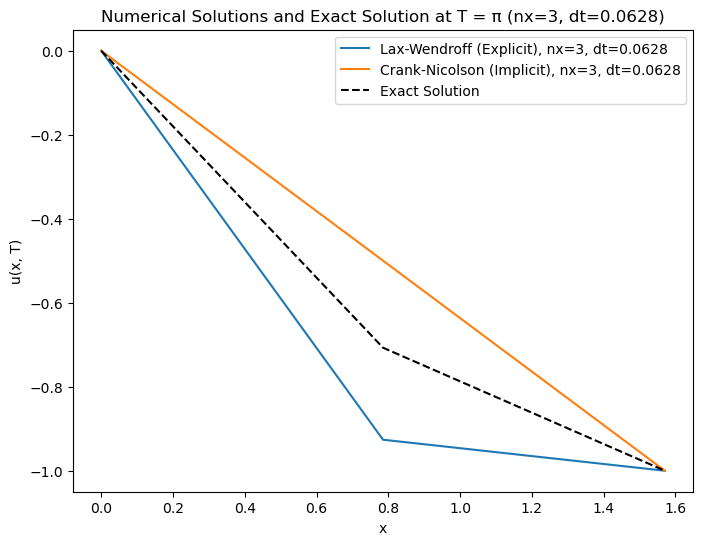

For nx=3, dt=0.0628:
Relative error for Lax-Wendroff Method (Explicit): 1.79e-01
Relative error for Crank-Nicolson Method (Implicit): 1.69e-01
----------------------------------------------------


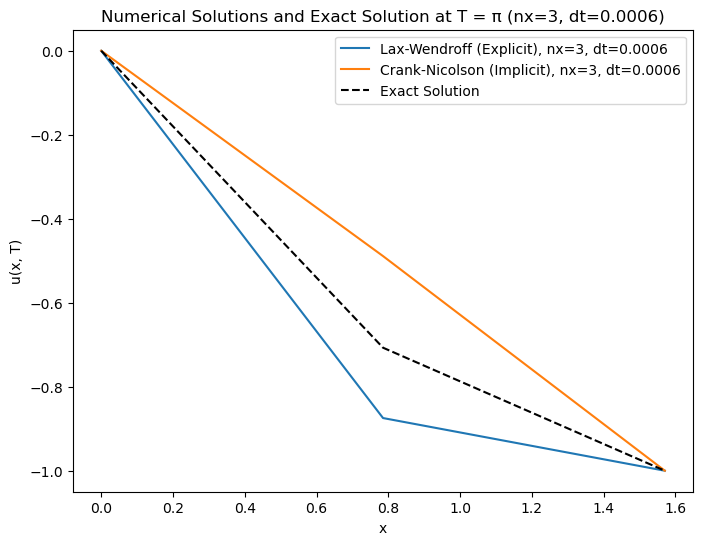

For nx=3, dt=0.0006:
Relative error for Lax-Wendroff Method (Explicit): 1.37e-01
Relative error for Crank-Nicolson Method (Implicit): 1.78e-01
----------------------------------------------------


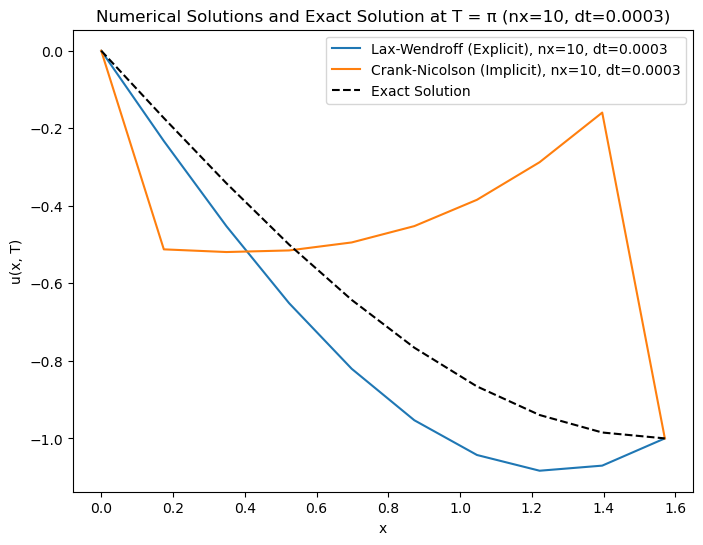

For nx=10, dt=0.0003:
Relative error for Lax-Wendroff Method (Explicit): 1.81e-01
Relative error for Crank-Nicolson Method (Implicit): 5.67e-01
----------------------------------------------------


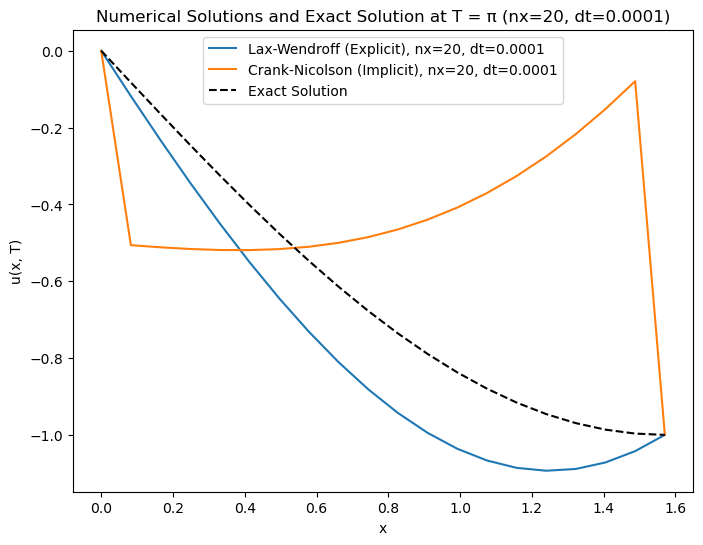

For nx=20, dt=0.0001:
Relative error for Lax-Wendroff Method (Explicit): 2.07e-01
Relative error for Crank-Nicolson Method (Implicit): 6.34e-01
----------------------------------------------------


In [56]:
# Parameters
L = np.pi / 2  # Spatial domain length
T = np.pi  # End time of the simulation

# Define different values of nx and dt for comparison
grid_settings = [
    {'nx': 3, 'alpha': 0.1},
    {'nx': 3, 'alpha': 0.001},
    {'nx': 10, 'alpha': 0.01},
    {'nx': 20, 'alpha': 0.01}
]

# Exact solution function for comparison
def exact_solution(x, t_val):
    return np.sin(x) * np.cos(t_val)

# Boundary conditions function, applying Dirichlet boundary conditions
def boundary_conditions(u, t_val):
    u[0] = 0  # u(0, t) = 0
    u[-1] = np.cos(t_val)  # u(L, t) = cos(t)

# Source term function as given in the equation
def source_term(x, t_val):
    return -np.sin(x) * np.sin(t_val) + np.sin(x) * np.cos(t_val)

# Main loop for testing different grid resolutions and stability factors
for setting in grid_settings:
    nx = setting['nx']  # Number of spatial grid points
    alpha = setting['alpha']  # Stability factor for explicit method
    
    # Calculate spatial and temporal step sizes
    dx = L / (nx - 1)  # Spatial step size
    dt = alpha * dx**2  # Time step size based on stability condition for explicit method
    nt = int(T / dt) + 1  # Calculate number of time steps to reach T
    dt = T / (nt - 1)  # Recalculate dt to ensure it exactly divides T

    # Generate spatial and temporal grids
    x = np.linspace(0, L, nx)  # Spatial grid points
    t = np.linspace(0, T, nt)  # Temporal grid points
    
    # Initialize arrays to store solutions for explicit and Crank-Nicolson methods
    u_explicit = np.zeros((nt, nx))  # Solution array for explicit method
    u_crank_nicolson = np.zeros((nt, nx))  # Solution array for Crank-Nicolson method
    
    # Set initial condition for both methods
    u_explicit[0, :] = np.sin(x)
    u_crank_nicolson[0, :] = np.sin(x)
    
    # Lax-Wendroff (Explicit) method with updated stability condition
    for n in range(0, nt - 1):
        # Apply boundary conditions for current time step
        boundary_conditions(u_explicit[n, :], t[n])
        for i in range(1, nx - 1):
            # Lax-Wendroff scheme to update interior points
            u_explicit[n + 1, i] = (u_explicit[n, i] 
                                    + 0.5 * alpha * (u_explicit[n, i + 1] - 2 * u_explicit[n, i] + u_explicit[n, i - 1])
                                    + dt * source_term(x[i], t[n]) 
                                    + 0.5 * (alpha ** 2) * (u_explicit[n, i + 1] - u_explicit[n, i - 1]))
        # Apply boundary conditions for next time step
        boundary_conditions(u_explicit[n + 1, :], t[n + 1])
    
    # Crank-Nicolson (Implicit) method with improved matrix filling and boundary handling
    A = np.zeros((nx - 2, nx - 2))  # Tridiagonal matrix for Crank-Nicolson
    B = np.zeros((nx - 2, nx - 2))  # Tridiagonal matrix for previous time step
    b = np.zeros(nx - 2)  # Right-hand side vector

    # Fill matrices A and B for Crank-Nicolson scheme
    for i in range(nx - 2):
        A[i, i] = 1 + alpha  # Main diagonal of A
        B[i, i] = 1 - alpha  # Main diagonal of B
        if i > 0:
            A[i, i - 1] = -0.5 * alpha  # Lower diagonal of A
            B[i, i - 1] = 0.5 * alpha  # Lower diagonal of B
        if i < nx - 3:
            A[i, i + 1] = -0.5 * alpha  # Upper diagonal of A
            B[i, i + 1] = 0.5 * alpha  # Upper diagonal of B

    # Time-stepping loop for Crank-Nicolson
    for n in range(0, nt - 1):
        # Apply boundary conditions for the current time step
        boundary_conditions(u_crank_nicolson[n, :], t[n])
        # Set up the right-hand side vector b for Crank-Nicolson
        b = B @ u_crank_nicolson[n, 1:-1] + dt * source_term(x[1:-1], t[n])
        # Adjust for boundary condition at right end
        b[0] += 0.5 * alpha * np.cos(t[n + 1])

        # Solve the tridiagonal system for the next time step
        u_crank_nicolson[n + 1, 1:-1] = np.linalg.solve(A, b)
        # Apply boundary conditions for the next time step
        boundary_conditions(u_crank_nicolson[n + 1, :], t[n + 1])
    
    # Calculate the exact solution at final time T for comparison
    u_exact = exact_solution(x, T)
    
    # Calculate relative errors for both methods
    norm_u_exact = np.linalg.norm(u_exact)  # Norm of the exact solution
    error_explicit = np.linalg.norm(u_explicit[-1, :] - u_exact) / norm_u_exact if norm_u_exact != 0 else np.nan
    error_crank_nicolson = np.linalg.norm(u_crank_nicolson[-1, :] - u_exact) / norm_u_exact if norm_u_exact != 0 else np.nan

    # Plot results: Numerical solutions and exact solution at T
    plt.figure(figsize=(8, 6))
    plt.plot(x, u_explicit[-1, :], label=f'Lax-Wendroff (Explicit), nx={nx}, dt={dt:.4f}')
    plt.plot(x, u_crank_nicolson[-1, :], label=f'Crank-Nicolson (Implicit), nx={nx}, dt={dt:.4f}')
    plt.plot(x, u_exact, 'k--', label='Exact Solution')
    plt.xlabel('x')
    plt.ylabel('u(x, T)')
    plt.legend()
    plt.title(f'Numerical Solutions and Exact Solution at T = π (nx={nx}, dt={dt:.4f})')
    plt.show()

    # Print errors for comparison
    print(f"For nx={nx}, dt={dt:.4f}:")
    print(f"Relative error for Lax-Wendroff Method (Explicit): {error_explicit:.2e}")
    print(f"Relative error for Crank-Nicolson Method (Implicit): {error_crank_nicolson:.2e}")
    print("----------------------------------------------------") 
